# Lompe example - North America

This an example of the Lompe technique applied in a grid over North America on 5 April 2012. The data input is from *SuperMAG* (ground magnetometers), *Iridium* (space magnetometer data, provided by [AMPERE](http://ampere.jhuapl.edu/)), and *SuperDARN* (ground radar measurements of line-of-sight F-region plasma convection). For simplicity we use the *Hardy et al. (1987)* model to specify auroral conductance. Solar conductance is calcualted by the method described in the Lompe paper. 

Start by loading relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe
import apexpy

##### Grid
Set up analysis grid and plot to see location and orientation on map (over North America).

(-0.29137431926458646, 0.28563352790201835)

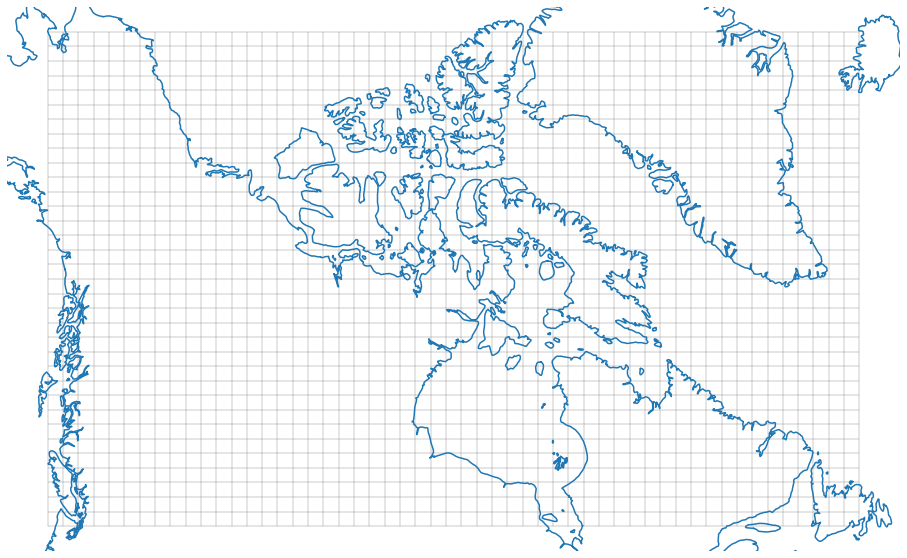

In [2]:
# cubed sphere grid parameters:
position = (-90, 68)  # lon, lat for grid center
orientation = 0       # angle of grid x axis - anti-clockwise from east direction
L, W = 7000e3, 3800e3 # extents [m] of grid
dL, dW = 100e3, 100e3 # spatial resolution [m] of grid 

# create grid object
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, dL, dW, R = 6481.2e3)

# plot grid and coastlines
fig, ax = plt.subplots(figsize = (16, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##### Input data
Next, load datasets. For this example, the files are pre-made and saved in *'./sample_dataset'*. See *Data_handling_with_Lompe* for explanation on how to get the data on this format.

In [3]:
event = '2012-04-05'
# file names and location
supermagfn = '../sample_dataset/20120405_supermag.h5'
superdarnfn = '../sample_dataset/20120405_superdarn_grdmap.h5' 
iridiumfn = '../sample_dataset/20120405_iridium.h5'

# load data
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn) 
iridium   = pd.read_hdf(iridiumfn)

The data must be passed to the lompe Emodel object (created later) as Lompe Data objects. The data that is passed to the Emodel object is the data that will be used in the inversion. However, the data objects above contain data from a whole day (5 April 2012), and we may want to loop over smaller subsets. Here is a function that returns subsets of the data:

In [4]:
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """
    
    # Iridium data:
    irid = iridium[(iridium.time >= t0) & (iridium.time <= t1)]
    irid_B = np.vstack((irid.B_e.values, irid.B_n.values, irid.B_r.values))
    irid_coords = np.vstack((irid.lon.values, irid.lat.values, irid.r.values))

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn.loc[t0:t1, :]
    vlos = sd['vlos'].values
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))

    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_fac', scale = 200e-9)
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'   , scale = 100e-9)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'   , scale = 500 )
    
    return(iridium_data, supermag_data, superdarn_data)


##### Set up model and run inversion
Now we have everything we need to set up the Lompe Emodel, add data, and run the inversion for the electric field. If we loop though the whole day, we will plot the output using a function called lompeplot and save the output so that it can be stitched together in a video later. 

For the conductance, we will use the Hardy model with Kp=4, in addition to solar EUV.

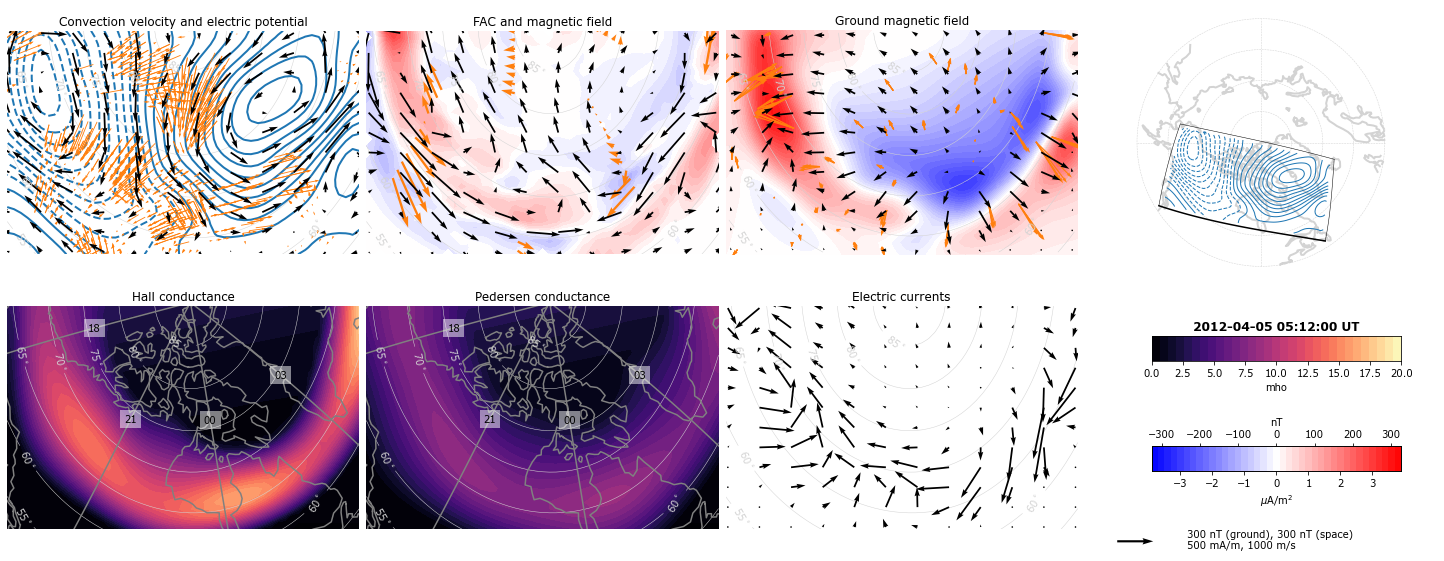

In [5]:
# time to plot for
T0 = dt.datetime(2012, 4, 5, 5, 12)
DT = dt.timedelta(seconds = 60 * 4) # length of time interval

# apex object for plotting in magnetic
apex = apexpy.Apex(T0, refh = 110)

# making conductance tuples
Kp = 4 # this is the input to the Hardy model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, T0, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, T0, 'pedersen')

# Create Emodel object. Pass grid and Hall/Pedersen conductance functions
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add datasets to model
iridium_data, supermag_data, superdarn_data = get_data_subsets(T0 - DT/2, T0 + DT/2) # data from new model time
model.add_data(iridium_data, supermag_data, superdarn_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10)

# finally, plot (plot is saved as specified path):
fig = lompe.lompeplot(model, include_data = True, time = T0, apex = apex, savekw = {'fname':'./output_figures/north_america.pdf'})

The top row shows, from left to right (input data is shown in orange): 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales

This is the end of the example.


#### Below you can test how it works when removing some of the input data:

If you want to get a Lompe model for a specific time *t* during the *event* date, you do not need to make an entirely new model if the model object already has been created. The grid/observation geometry, apex, IGRF, etc. will stay the same throughout the entire day. What is changing is the input data. We can replace the input data in the model object using the class function *clear_model()*.

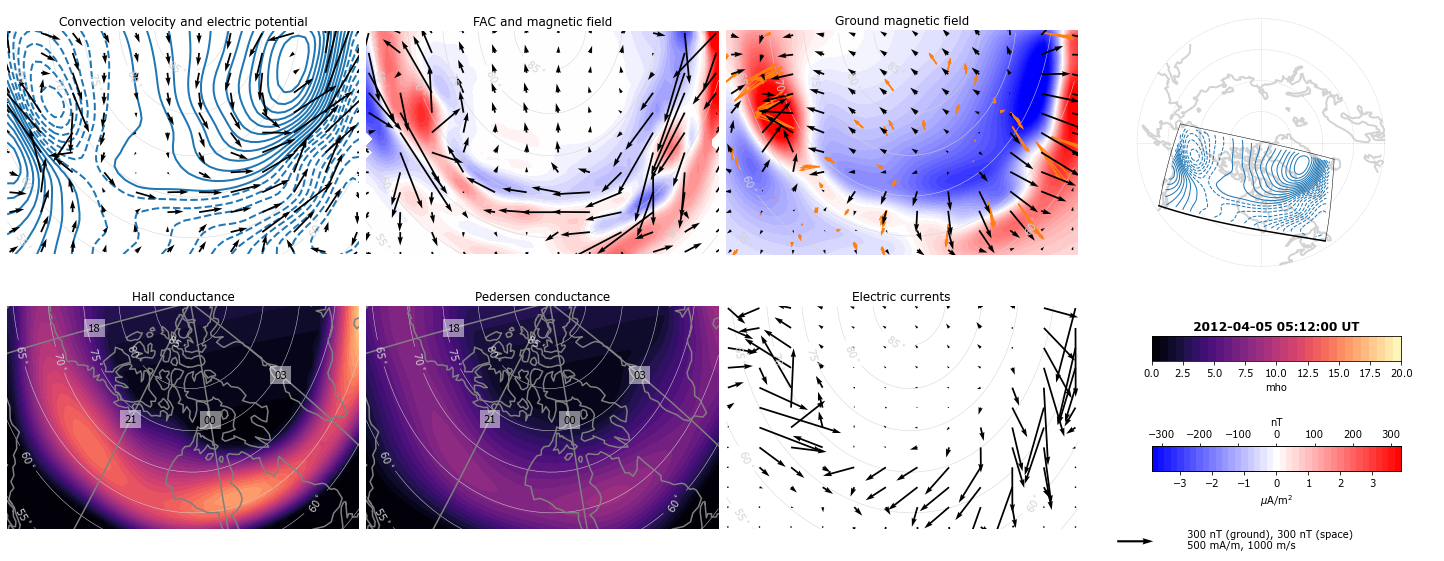

In [6]:
# clear model and pass conductances
model.clear_model(Hall_Pedersen_conductance = (SH, SP))

################
# Here you can experiment with adding only some of the datasets to the model by changing which lines are comments:

#model.add_data(iridium_data)
model.add_data(supermag_data)
#model.add_data(superdarn_data)

################

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10)

# Finally, plot:
fig = lompe.lompeplot(model, include_data = True, time = T0, apex = apex, savekw = {'fname':'./output_figures/north_america_mag.pdf'})

See how the model output changes when varying the different sources of input data.